# Ensemble experiments on insurance data

The goal of this notebook is to explore different methods of ensembling model outputs. Ensemble models can be used when you have several models to predict the same target, and your aim is to combine. 

Content:
1. Imports 
2. Exploration
3. Train a Generalised Linear Model, XGBoost and Random Forest
4. Weighted average ensemble 
5. Stacking 
6. Conclusion

# Imports 

In [1]:
import os
import warnings



import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import xgboost as xgb

from scipy.integrate import trapz
from scipy.optimize import linprog
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

In [2]:
# train = pd.read_csv('data/train.csv')
# test = pd.read_csv('data/test.csv')
# sample_submission = pd.read_csv('data/sample_submission.csv')
train = pd.read_csv('gs://cytora-user-wout/train.csv')
test = pd.read_csv('gs://cytora-user-wout/test.csv')
sample_submission = pd.read_csv('gs://cytora-user-wout/sample_submission.csv')

# Data exploration

The dataset comes from [kaggle](https://www.kaggle.com/c/allstate-claims-severity/data). It's a claims dataset from some insurer. All rows represent one claim, there is one unique identifyer, 130 features and one loss column which represents the monetary amount of the loss. 

In [66]:
train.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


## Train

In [63]:
train.shape

(188318, 589)

In [4]:
cat_features = [feature for feature in list(train) if 'cat' in feature]
print('{} categorical features'.format(len(cat_features)))

cont_features = [feature for feature in list(train) if 'cont' in feature]
print('{} of continuous features: '.format(len(cont_features)))

116 categorical features
14 of continuous features: 


Ensure we captured all features

In [5]:
assert len(cat_features) + len(cont_features) + 2 == train.shape[1] # The 2 in this line represents the id and loss column

### Categorical features 

How many categories do the categorical features have? 

In [6]:
cat_nr_dict = {}

for cat in cat_features:
    cat_nr_dict[cat] = train[cat].nunique()

In [7]:
cat_nr_series = pd.Series(cat_nr_dict)

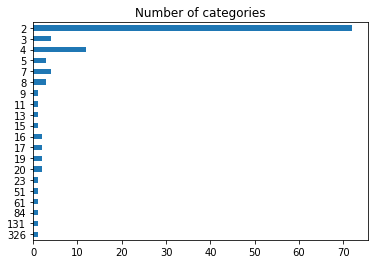

In [10]:
cat_nr_series.value_counts().sort_index(ascending=False).plot('barh', title='Number of categories');

In this graph we see most categorical variables only have 2 unique entries. There are a couple columns that have more than 50 categories. Small categories might add noise to a model, especially when you need to convert categories to dummies, which is the case for GLMs in statsmodels and XGBoost, which both are unable to read strings. 

In [11]:
for i in cat_nr_series.value_counts().sort_index()[-6:].index:
    
    perc = sum(train[cat_nr_series[cat_nr_series == i].index[0]].value_counts(normalize=1) < 0.01) / i

    print('Nr of categories: ', i)
    print('Perc of categories smaller than 1%: ', perc)
    print()

Nr of categories:  23
Perc of categories smaller than 1%:  0.5217391304347826

Nr of categories:  51
Perc of categories smaller than 1%:  0.5882352941176471

Nr of categories:  61
Perc of categories smaller than 1%:  0.5737704918032787

Nr of categories:  84
Perc of categories smaller than 1%:  0.9523809523809523

Nr of categories:  131
Perc of categories smaller than 1%:  0.8625954198473282

Nr of categories:  326
Perc of categories smaller than 1%:  0.9233128834355828



For the algorithms where we need to create dummies from categorical variables, we can cut off at category being represented in <1% of the rows

In [12]:
def to_other_cat(df, col, cut_off):
    """Converts categories below cut off value to other"""
    df = df.copy()
    vc = df[col].value_counts(normalize=1)
    small_category = vc < cut_off
    small_category_list = list(small_category.index[small_category])
    small_category_filter = df[col].isin(small_category_list)
    df.loc[small_category_filter, col] = 'other'
    return df[col]

Let's create the columns in both the train and test dataset. In the test set, different categories might fall under 1%, therefore we write this in the same for loop

In [13]:
cut_off = 0.01

for feat in cat_features:
    train[feat + '_o'] = to_other_cat(train, feat, 0.01)
    
    # we need to ensure the same categories exist in the test set for when we make predictions
    test[feat + '_o'] = test[feat]
    
    keep_list = list(set(train[feat + '_o']))

    test.loc[~test[feat].isin(keep_list), feat + '_o'] = 'other'

Let's create the dummy categories based on our new columns as well

In [14]:
cat_other_features = [feat for feat in list(train) if '_o' in feat]

In [15]:
cat_dummy_features = []

for feat in cat_other_features:
    train_dummy_df = pd.get_dummies(train[feat], prefix=feat, drop_first=True)
    
    dummy_features = list(train_dummy_df)
    
    train[dummy_features] = train_dummy_df
    
    cat_dummy_features = cat_dummy_features + dummy_features
    
    test_dummy_df = pd.get_dummies(test[feat], prefix=feat)
    
    test[dummy_features] = test_dummy_df[dummy_features]

Assert test and train contain the exact same columns, exept for the target variable in the train dataset

In [16]:
assert set(list(test)) - set(list(train)) == set()

In [17]:
assert set(list(train)) - set(list(test)) == {'loss'}

The cat_dummy_features should all be boolean now

In [18]:
assert (train[cat_dummy_features].dtypes == 'uint8').all()

Random slice of the categoricals

In [19]:
train[cat_dummy_features].sample(5).T.sample(5).T

,cat113_o_H,cat115_o_L,cat105_o_other,cat79_o_B,cat107_o_F
83240,0,0,0,1,1
169672,0,0,0,1,0
177331,0,0,0,0,1
158319,0,0,0,1,0
66773,0,0,0,1,1


### Continuous features 

Let's take a look at the distributions 

''

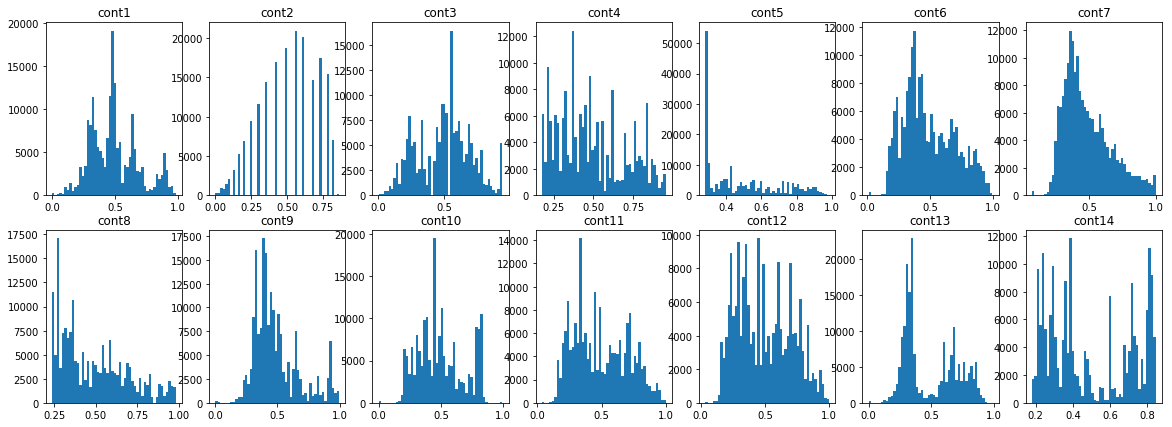

In [20]:
fig, ax = plt.subplots(ncols=7, nrows=2, figsize=(20, 7))

k=0
for j in range(2):
    for i in range(7):
        ax[j,i].hist(train[cont_features[k]], bins=50)
        ax[j,i].set_title(cont_features[k])
        k+=1
;

They all seem nicely spread between 0 and 1 and it seems there is no need to logtransform

Maybe cont2 can be changed to categorical variable.

In [21]:
c2_un = train['cont2'].nunique()
print('Cont2 has {} unique elements'.format(c2_un))

Cont2 has 33 unique elements


Hard to determine without context on what the variable represents, might be something like age in which case continuous makes sense. 

### Target variable

Let's look at the distribution of the target variable

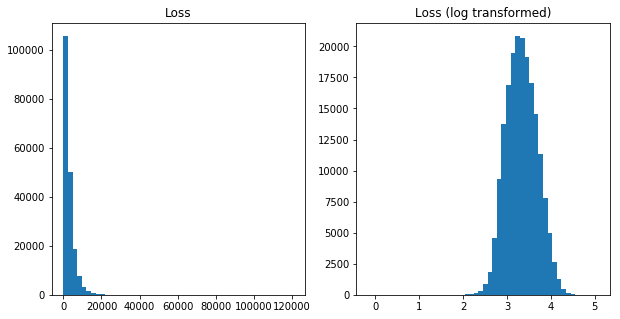

In [70]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].hist(train['loss'], bins=50);
ax[0].set_title('Loss')
ax[1].hist(np.log10(train['loss']), bins=50);
ax[1].set_title('Loss (log transformed)');

A typical distribution for insurance claims is the [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution). By eyeballing it seems like this is is the case here as well, for now we'll assume a Gamma distribution. 

## Test +  sample submission

In [23]:
test.shape

(125546, 588)

In [24]:
sample_submission.shape

(125546, 2)

Make sure the id positions of the sample submission and test df are the same in case we want to submit it to kaggle

In [25]:
assert pd.Series(test['id'] == sample_submission['id']).all()

## Evaluation

Let's define a [Lorenz curve](https://en.wikipedia.org/wiki/Lorenz_curve). This is a nice way to get an idea of whether you can rank the claims by riskiness well. It can lead to a statement like: the 50% of the least risky exposures (according to our model) cover 20% of their total loss, and the 50% riskiest claims cover 80% of their total loss. This would mean the model is working. 

In [26]:
def lorenz_curve(risk_proxy, loss):
    idx = np.argsort(risk_proxy)
    
    ordered_loss = loss[idx]
    cum_loss =  ordered_loss.cumsum() / sum(loss)
    x_axis = np.linspace(0,1,len(cum_loss))
    
    return np.append([0], x_axis), np.append([0], cum_loss)

In [27]:
def score(x, y):
    integral = trapz(y, x)
    output = 1 - 2 * integral 
    
    return output

In [28]:
def lorenz_plot(df, list_of_risk_proxies, loss):
    
    fig, ax = plt.subplots(figsize=(10,10))
    for i in range(len(list_of_risk_proxies)):
        y = lorenz_curve(df[list_of_risk_proxies[i]].values, df[loss].values)
        score_y = score(y[0], y[1])
        
        legend = list_of_risk_proxies[i] + ', score: ' + str(np.round(score_y,2))
        
        ax.plot(y[0], y[1], label=legend);
        
    ax.set_xlim(0,1.01)
    ax.set_ylim(0,1.01)
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    ax.legend()

In [77]:
np.random.rand(1,10)[0]

array([0.68722091, 0.40229157, 0.74520305, 0.28909525, 0.23203074,
       0.99711207, 0.15765175, 0.98136004, 0.92651   , 0.71467574])

In [86]:
thing = pd.DataFrame({
    'x1': np.random.rand(1,1000)[0] * np.random.randint(1000), 
    'x2': np.random.rand(1,1000)[0] * np.random.randint(1000),
    'x3': np.random.rand(1,1000)[0] * np.random.randint(1000),
    'x4': np.random.rand(1,1000)[0] * np.random.randint(1000),
    'loss': np.random.rand(1,1000)[0] #* np.random.randint(100)
#     'loss':np.array([11,3,2,5,66,9,4,5,7,3])
})

thing['x2'] = thing['x2'] *  thing['loss']
thing['x4'] = thing['x4'] *  thing['loss']

This is what a Lorenz plot looks like

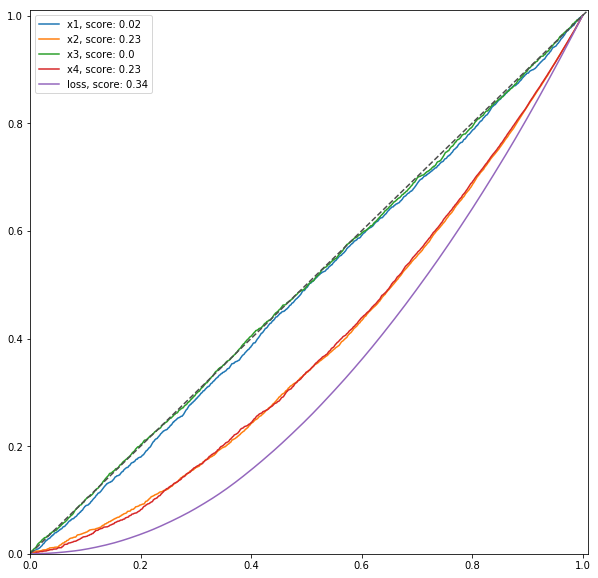

In [88]:
lorenz_plot(thing, ['x1', 'x2', 'x3', 'x4', 'loss'], 'loss')

So we know x2 and x4 have information about the model, and you can see there are more predictive. The maximum score is 1, which is only possible if the exposures without claims are also taken into acount. Now all exposures have a claim which means the maximum score is 0.34. 

# Process for modelling

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    train.drop('loss', axis=1),
    train[['loss']],
    test_size=0.33, 
    random_state=42
)

In [34]:
X_train.head(2)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cat116_o_HX,cat116_o_IE,cat116_o_IG,cat116_o_KW,cat116_o_LB,cat116_o_LM,cat116_o_LN,cat116_o_LO,cat116_o_MD,cat116_o_other
31228,98041,A,A,A,B,A,A,A,A,A,...,0,0,0,0,0,0,0,0,0,0
75562,236254,B,A,A,A,A,B,A,A,A,...,0,0,0,0,0,0,0,0,0,0


In [35]:
y_train.head(2)

,loss
31228,840.33
75562,1303.28


# Models

Let's train a couple of models

### GLM

In [36]:
assert X_train[cat_dummy_features + cont_features].notnull().all().all()

In [37]:
def train_glm(df, target, feature_list, output='results'):
    glm = smf.GLM(
        exog=sm.add_constant(df[feature_list]).astype(float).values,
        endog=target.astype(float).values,
        family=sm.families.Gamma(),
    )

    results_glm = glm.fit()
    

    if output == 'results':
        return results_glm.summary2(xname=['const'] + list(df[feature_list]))
    if output == 'model':
        return glm, results_glm

In [38]:
results_continuous = train_glm(X_train, y_train, cont_features)

In [39]:
results_continuous

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Generalized linear model
==================================================================
Model:              GLM              AIC:            2256545.6809 
Link Function:      inverse_power    BIC:            -1401931.0934
Dependent Variable: y                Log-Likelihood: -1.1283e+06  
Date:               2019-05-24 09:21 LL-Null:        -1.1312e+06  
No. Observations:   126173           Deviance:       79846.       
Df Model:           14               Pearson chi2:   9.43e+04     
Df Residuals:       126158           Scale:          0.74763      
Method:             IRLS                                          
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const      0.0005     0.0000    83.9685   0.0000    0.0005    0.0005
cont1      0.0002     0.0000    14.2305   0.0000    0.0002    0.0002
cont2     -0.0002     0.0000   -40.7400   0.0000   -0.0002   -0.0002
cont3      0.0000     0.0000     0.0685   0.9454   -0.0000    0.0000
cont4      0.0000     0.0000     7.4573   0.0000    0.0000    0.0001
cont5     -0.0000     0.0000    -2.1149   0.0344   -0.0000   -0.0000
cont6      0.0000     0.0000     2.3404   0.0193    0.0000    0.0001
cont7     -0.0001     0.0000   -16.4038   0.0000   -0.0002   -0.0001
cont8     -0.0000     0.0000    -6.4799   0.0000   -0.0000   -0.0000
cont9     -0.0002     0.0000   -13.6724   0.0000   -0.0002   -0.0002
cont10     0.0000     0.0000     2.2026   0.0276    0.0000    0.0000
cont11     0.0001     0.0000     3.3029   0.0010    0.0000    0.0002
cont12    -0.0002     0.0000    -5.7861   0.0000   -0.0003   -0.0001
cont13     0.0000     0.0000     5.0341   0.0000    0.0000    0.0001
cont14    -0.0000     0.0000    -7.8635   0.0000   -0.0000   -0.0000
==================================================================

"""

In [40]:
results_continuous_significance = results_continuous.tables[1]['P>|z|']
continuous_significant_features = list(results_continuous_significance[results_continuous_significance<0.05].index)

In [41]:
categorical_significant_features = []

In [42]:
for i in range(0, len(cat_features)):
    temp_dummy_feature_list = [dummy_cat for dummy_cat in cat_dummy_features if cat_features[i] + '_o' in dummy_cat]
    temp_res = train_glm(X_train, y_train, temp_dummy_feature_list)
    temp_significance = temp_res.tables[1].loc[temp_dummy_feature_list, 'P>|z|']
    categorical_significant_features = categorical_significant_features + list(temp_significance[temp_significance < 0.05].index)

In [43]:
significant_features = [x for x in categorical_significant_features + continuous_significant_features if 'const' not in x]

In [44]:
glm, results_glm = train_glm(
    X_train,
    y_train,
    significant_features,
    output='model'
)

In [45]:
pred_glm = glm.predict(
    exog=sm.add_constant(X_test[significant_features]).astype(float).values,
    params=results_glm.params, 
)

# TODO: why are there negative values

### Results

In [47]:
def rmse(y_test, pred):
    return np.sqrt(mean_squared_error(y_test, pred))

In [50]:
rmse(y_test, pred_glm)

231685.31722080102

In [51]:
test['pred_glm'] = glm.predict(
    exog=sm.add_constant(test[significant_features]).astype(float).values,
    params=results_glm.params, 
)


### XGB

Parameters

In [52]:
params = {
    'objective': 'reg:gamma',
    'max_depth': 4,
    'eta': 0.2,
    'eval_metric': 'gamma-nloglik',
    'nthread': os.cpu_count() - 1,
    'silent': True,
    'booster': 'gbtree',
    'colsample_bytree': 1,
    'gamma': 0,
    'max_delta_step': 0,
    'min_child_weight': 1,
    'subsample': 1,
}



In [53]:
def train_xgb(X_train, y_train, feature_list, params):
    
    num_boost_round = 1000
    cv_folds = 5
    early_stopping_rounds = 10
    early_stopping_cv_folds = 5
    verbose_eval = 10
    early_stopping_cv_fold_seed = 42
    
    X = X_train[feature_list].values
    y = y_train.values
    
    D_train = xgb.DMatrix(
        data=X,
        label=y,
        feature_names=feature_list,
        missing=np.nan, 
    )
    
    results = xgb.cv(
        params=params,
        dtrain=D_train,
        num_boost_round=num_boost_round,
        early_stopping_rounds=early_stopping_rounds,
        nfold=early_stopping_cv_folds,
        as_pandas=True,
        verbose_eval=verbose_eval,
        seed=early_stopping_cv_fold_seed
    )
    
    opt_num_boost_round = len(results)

    bst = xgb.train(
        params=params,
        dtrain=D_train,
        num_boost_round=opt_num_boost_round,
    )
    
    return bst

In [54]:
booster = train_xgb(X_train, y_train, cont_features + cat_dummy_features, params)

[0]	train-gamma-nloglik:4970.88+8.4945	test-gamma-nloglik:4970.88+33.9785
[10]	train-gamma-nloglik:675.089+1.14951	test-gamma-nloglik:675.09+4.60373
[20]	train-gamma-nloglik:95.4364+0.155575	test-gamma-nloglik:95.4364+0.62559
[30]	train-gamma-nloglik:18.6477+0.0211373	test-gamma-nloglik:18.6483+0.0870737
[40]	train-gamma-nloglik:9.58495+0.00331295	test-gamma-nloglik:9.58537+0.0152481
[50]	train-gamma-nloglik:8.8968+0.00156125	test-gamma-nloglik:8.89765+0.00643987
[60]	train-gamma-nloglik:8.85441+0.0015901	test-gamma-nloglik:8.8558+0.00571844
[70]	train-gamma-nloglik:8.84261+0.00158198	test-gamma-nloglik:8.84459+0.00579368
[80]	train-gamma-nloglik:8.83677+0.00167194	test-gamma-nloglik:8.83935+0.00580392
[90]	train-gamma-nloglik:8.83338+0.00180788	test-gamma-nloglik:8.83646+0.00580797
[100]	train-gamma-nloglik:8.83099+0.00183094	test-gamma-nloglik:8.8346+0.00585041
[110]	train-gamma-nloglik:8.82919+0.00173918	test-gamma-nloglik:8.83331+0.00601616
[120]	train-gamma-nloglik:8.82769+0.00174

In [55]:
D_test = xgb.DMatrix(    
    data=X_test[cont_features + cat_dummy_features].values,
    feature_names= cont_features + cat_dummy_features,
    missing=np.nan, 
)

pred_xgb = booster.predict(D_test)

In [56]:
rmse(pred_xgb, y_test)

1892.6111022663472

In [57]:
D_test_final = xgb.DMatrix(    
    data=test[cont_features + cat_dummy_features].values,
    feature_names= cont_features + cat_dummy_features,
    missing=np.nan, 
)

In [58]:
test['pred_xgb'] = booster.predict(D_test_final)

### Random Forest

In [59]:
rf = RandomForestRegressor()

In [60]:
rf.fit(X_train[cont_features + cat_dummy_features], y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [61]:
pred_rf = rf.predict(X_test[cont_features + cat_dummy_features])

In [89]:
rmse(pred_rf, y_test)

2071.159251313066

In [90]:
test['pred_rf'] = rf.predict(test[cont_features + cat_dummy_features])

# Ensemble

In [92]:
comparison = pd.DataFrame({
    'y_test': y_test['loss'],
    'pred_glm': pred_glm,
    'pred_rf': pred_rf,
    'pred_xgb': pred_xgb,
    
}).sort_values('y_test')

## Weighted average ensemble

In [98]:
comparison['rf_xgb_ens'] = 0.1 * comparison['pred_rf'] + 0.9 * comparison['pred_xgb']

In [99]:
rmse(comparison['pred_xgb'], comparison['y_test'])

1892.6111022663474

In [100]:
rmse(comparison['rf_xgb_ens'], comparison['y_test'])

1885.8765488968004

With this composition we have already improved the xgboost. Let's find the optimal weights. 

Finding the optimal weights

In [102]:
smallest_rmse = np.inf

lin_space = np.linspace(0,1,21)

for z in lin_space:
    for y in lin_space:
        for x in lin_space:
            if x + y + z == 1:
                x = np.round(x,2)
                y = np.round(y,2)
                z = np.round(z,2)
                
                comparison['optimal_stack_ensemble'] = x * comparison['pred_glm'] + y * comparison['pred_xgb'] + z * comparison['pred_rf']
                
                previous_rmse = smallest_rmse
                current_rmse = rmse(comparison['optimal_stack_ensemble'], comparison['y_test'])
                
                if current_rmse < smallest_rmse:
                    smallest_rmse = current_rmse
                    print('Optimal weights: {} with rmse {}'.format((x,y,z), smallest_rmse))
                    comparison['optimal_stack_ensemble'] = x * comparison['pred_glm'] + y * comparison['pred_xgb'] + z * comparison['pred_rf']

Optimal weights: (1.0, 0.0, 0.0) with rmse 231685.317220801
Optimal weights: (0.95, 0.05, 0.0) with rmse 220100.1619833917
Optimal weights: (0.9, 0.1, 0.0) with rmse 208515.05194858552
Optimal weights: (0.85, 0.15, 0.0) with rmse 196929.99509410307
Optimal weights: (0.8, 0.2, 0.0) with rmse 185345.00139176997
Optimal weights: (0.75, 0.25, 0.0) with rmse 173760.0834730627
Optimal weights: (0.7, 0.3, 0.0) with rmse 162175.25758004538
Optimal weights: (0.65, 0.35, 0.0) with rmse 150590.5449478439
Optimal weights: (0.6, 0.4, 0.0) with rmse 139005.97389907457
Optimal weights: (0.55, 0.45, 0.0) with rmse 127421.58304436092
Optimal weights: (0.5, 0.5, 0.0) with rmse 115837.42644916964
Optimal weights: (0.45, 0.55, 0.0) with rmse 104253.58220037611
Optimal weights: (0.4, 0.6, 0.0) with rmse 92670.16743227793
Optimal weights: (0.35, 0.65, 0.0) with rmse 81087.36619291904
Optimal weights: (0.3, 0.7, 0.0) with rmse 69505.48521642639
Optimal weights: (0.25, 0.75, 0.0) with rmse 57925.07651369358
O

So the optimal weighted average is 0.85 XGB, 0.15 RF. 

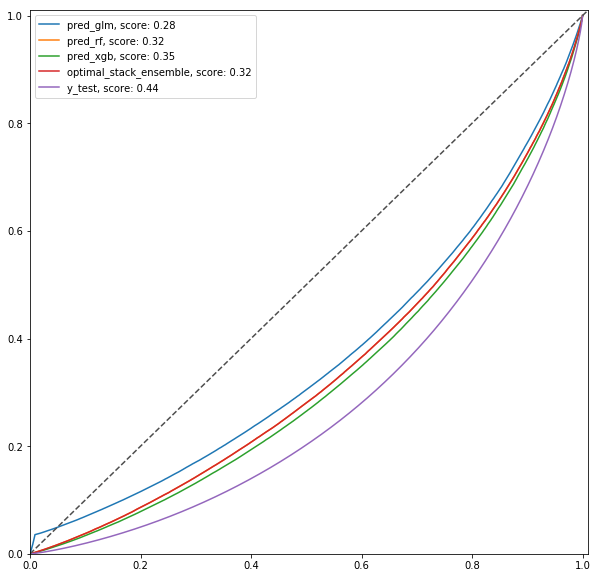

In [106]:
lorenz_plot(
    comparison,
    ['pred_glm', 'pred_rf', 'pred_xgb', 'optimal_stack_ensemble', 'y_test'],
    'y_test'   
)

## Stacking

One other method is to train a new model on the target with the three model outputs as input additional to the original input, which is called stacking. 

Sometimes on subsets of the data one model is better, where on the other parts of the data another model is better. Why not let a decision tree figure this out for you? 

In [111]:
from sklearn.tree import DecisionTreeRegressor

In [112]:
X_train.shape

(126173, 588)

In [114]:
X_train_stack = X_train.copy()

In [115]:
X_train_stack['glm'] = glm.predict(
    exog=sm.add_constant(X_train[significant_features]).astype(float).values,
    params=results_glm.params, 
)

In [118]:
D_train_stack = xgb.DMatrix(    
    data=X_train[cont_features + cat_dummy_features].values,
    feature_names= cont_features + cat_dummy_features,
    missing=np.nan, 
)

X_train_stack['xgb'] = booster.predict(D_train_stack)

In [119]:
X_train_stack['rf'] = rf.predict(X_train[cont_features + cat_dummy_features])

In [146]:
regr_3 = DecisionTreeRegressor(max_depth=3)
regr_3.fit(X_train_stack[cont_features + cat_dummy_features + ['glm', 'xgb', 'rf']], y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [130]:
X_test_stack = X_test.copy()
X_test_stack[['glm', 'xgb', 'rf']] = comparison[['pred_glm', 'pred_xgb', 'pred_rf']]

In [147]:
comparison['stacked_model'] = regr_3.predict(X_test_stack[cont_features + cat_dummy_features + ['glm', 'xgb', 'rf']])

In [148]:
rmse(comparison['stacked_model'], comparison['y_test'])

3753.0200292514915

Ok that didn't work, I actually think my data is contaminated because I predicted on the dataset I trained on to get the feature in the training set.  

## Other idea

What if we predict the probability that a model is closest, based on all the data? 

In [154]:
X_train_stack['loss'] = y_train

In [158]:
for model in ['glm', 'rf', 'xgb']:
    X_train_stack['{}_diff'.format(model)] = (X_train_stack['loss'] - X_train_stack[model]).abs()

In [164]:
X_train_stack[['glm_diff', 'rf_diff', 'xgb_diff']].idxmin(axis=1).value_counts()

rf_diff     90313
xgb_diff    19650
glm_diff    16210
dtype: int64

In [165]:
X_train_stack['closest_model'] = X_train_stack[['glm_diff', 'rf_diff', 'xgb_diff']].idxmin(axis=1)

In [168]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

In [170]:
clf.fit(X_train_stack[cont_features + cat_dummy_features], X_train_stack['closest_model'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [175]:
list(clf.classes_)

['glm_diff', 'rf_diff', 'xgb_diff']

In [172]:
ideal_weights = clf.predict_proba(X_test[cont_features + cat_dummy_features])

In [185]:
for i in range(3):
    comparison[list(clf.classes_)[i]] = ideal_weights.T[i]

In [187]:
comparison['ideal_weighted_model'] = comparison['pred_glm'] * comparison['glm_diff'] + comparison['pred_rf'] * comparison['rf_diff'] + comparison['pred_xgb'] * comparison['xgb_diff']

In [188]:
rmse(comparison['ideal_weighted_model'], comparison['y_test'])

30084.45455208937

Oh nooo!! This is also happening because my GLM is crap. 

# Conclusion

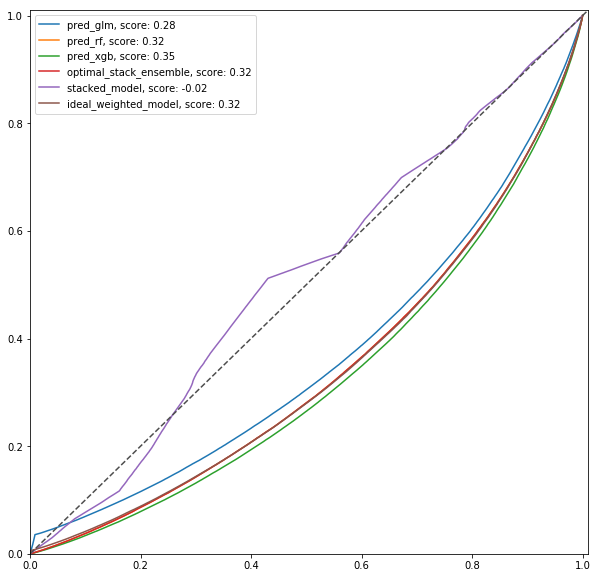

In [190]:
lorenz_plot(
    comparison,
    ['pred_glm', 'pred_rf', 'pred_xgb', 'optimal_stack_ensemble', 'stacked_model', 'ideal_weighted_model'],
    'y_test'   
)

XGBoost is still the best at differentiating risk. The best RMSE is achieved by a weighted average of XGBoost and Random Forest. 

# Appendix

#### Shap values

In [107]:
import shap

In [108]:
explainer = shap.TreeExplainer(booster)

In [109]:
shap_values = explainer.shap_values(X_test[cont_features + cat_dummy_features])

In [135]:
#shap.initjs()
#shap.force_plot(explainer.expected_value, shap_values, X_test[cont_features + cat_dummy_features])

This is not the most exciting when you don't know what the features represent, and takes way too long with this amount of features. 

#### Results 

Not interested in uploading yet, since the leaderboard has scores around 1100 

In [ ]:
test['optimal_stack_ensemble'] = 0.85 * test['pred_xgb'] + 0.15 * test['pred_rf']

In [ ]:
sample_submission['loss'] = test['optimal_stack_ensemble']

In [ ]:
sample_submission.to_csv(...)